## 1. Getting started

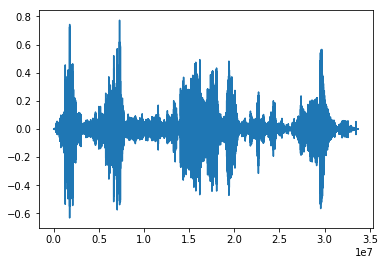

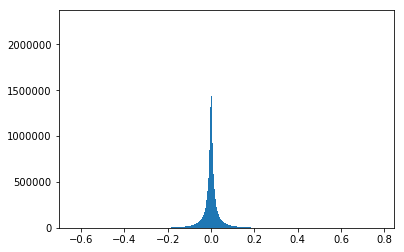

In [2]:
%matplotlib inline
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

#load dataset
mat_contents = scipy.io.loadmat("/afs/inf.ed.ac.uk/group/teaching/mlprdata/audio/amp_data.mat")
amp_data = mat_contents['amp_data']
#histogram
plt.plot(amp_data)
plt.show()
plt.hist(amp_data, bins=1000)
plt.show()
#reshape dataset
row_num = amp_data.shape[0]
remainder = row_num % 21;
amp_data = amp_data[0:(row_num-remainder)];
amp_data = amp_data.reshape((-1,21))

In [4]:
#shuffle rows of the matrix
np.random.seed(0)
rand_perm = np.random.permutation(amp_data.shape[0])
shuf_data = amp_data[rand_perm,:]
row_num = shuf_data.shape[0]
train = shuf_data[:round(row_num*0.7),:]
val = shuf_data[round(row_num*0.7):round(row_num*0.85),:]
test = shuf_data[round(row_num*0.85):,:]

X_shuf_train = train[:,:20];
y_shuf_train = train[:,20];
X_shuf_val = val[:,:20];
y_shuf_val = val[:,20];
X_shuf_test = test[:,:20];
y_shuf_test = test[:,20];

print(X_shuf_train.shape, y_shuf_train.shape)
print(X_shuf_val.shape, y_shuf_val.shape)
print(X_shuf_test.shape, y_shuf_test.shape)

(1123776, 20) (1123776,)
(240809, 20) (240809,)
(240809, 20) (240809,)


## 2. Curve fitting on a snippet of audio:
### a) Plot 20 training points, a test point, a straight line fit, and a quartic fit. 

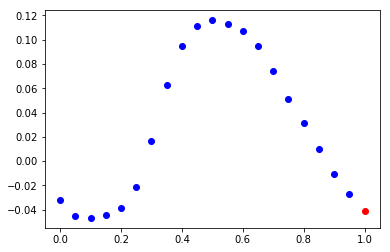

In [24]:
#plot dataset
X = X_shuf_train[0,:]
tt = np.arange(0,1,1/20)
tt = np.arange(0,1,1/20)[:,None]
# print(x.shape)
# print(t.shape)
# print(amp_data.shape)
# print(amp_data)
plt.plot(t,x,'bo')
plt.plot(1,y_shuf_train[0],'ro')
plt.show()

In [35]:
#linear fit by least squares
def phi_linear(X):
    return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)
ww = np.linalg.lstsq(phi_linear(tt), X, rcond=-1)[0]
print(ww)

[-0.00631757  0.07824478]


In [39]:
#quartic fit
def phi_quartic(X):
    return np.concatenate([np.ones((X.shape[0],1)),\
                           X, X**2, X**3, X**4], axis=1)
ww = np.linalg.lstsq(phi_quartic(tt), X, rcond=-1)[0]
print(ww)

[-0.02265502 -0.88557282  5.9969478  -9.63376427  4.52822088]


## 3. Choosing a polynomial predictor based on performance

In [ ]:
order = 4

def ls(x,y):
    y=np.dot(x.T,y)
    y=np.reshape(y,(-1,1))
    xx=np.dot(x.T,x)
    xx=np.mat(xx)
    x=xx.I
    c=x*y
    print(c)
    return c

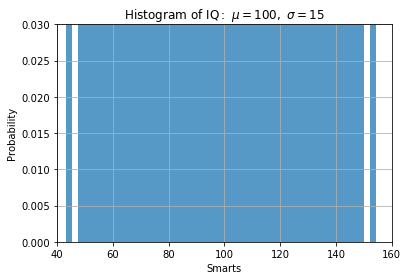

In [5]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

mu, sigma = 100, 15
x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, alpha=0.75)

# add a 'best fit' line

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()
